# Segmentation

In this final section, a segmentation CNN is constructed in order to extract the foreground from an image. This segmentation CNN can be regarded as a binary classification CNN, assigning every pixel in the image to a label (pixel-wise classiﬁcation).  As such, each pixel gets a label of belonging to a certain object or not and the result is a segmented image. In more detail, each pixel belonging to the foreground is classified to label 1 and every pixel belonging to the background is classified to label 0 (semantic segmentation). 

For this task, one of the autoencoders presented in the first part is used, having as output one channel image though. Moreover, different loss functions are used in this case (**Dice Loss, Weighted Cross-Entropy, Binary Cross-Entropy**) and apart from the accuracy, a different range of metrics is calculated in this segmentation task. 

Data Augmentation:
Since the numbers of data was not sufficient data augmentation was applied using rotation techniques, so that increase the training images. However, it was noticed that when all of them were used, the network was overfitting even from the second run, so usually a part of them was used (either 1100 or 1200 training images). 
Finally, the image size was reduced to 144x144 because the training was slower otherwise.

We train the network and visualize the training and validation learning curves. Here, we notice that the loss or other standard metrics like accuracy are less meaningful and there exist better metrics for the model evaluation.

**Metrics Calculated**: 
* **Intersection over Union (IoU)**: Intersection over union also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and the prediction output. This metric is closely related to the Dice coefficient. Quite simply, the IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks. The IoU score is calculated for each class separately and then averaged over all classes to provide a global, mean IoU score of our semantic segmentation prediction. 

* **Dice score**, also referred to as **F-score**, is an important image overlap metric, especially in image segmentation tasks. Also, it is worth mentioning here that IoU and F-score are always within a factor of 2 of each other: F/2≤IoU≤F, and also that they meet at the extremes of one and zero under the conditions that someone would expect (perfect match and completely disjoint). 

* **Receiver Operating Characteristic (ROC)**: ROC-AUC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much model is capable of distinguishing between classes. This performance measurement was selected, since the task is treated as a binary classification problem.   

Finally, using a threshold, we visualize our segmented images in a nice way.

#### Download the data

In [0]:
!wget -cq http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
!tar -xvf VOCtrainval_11-May-2009.tar

#### Import the right packages

In [0]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from matplotlib import pyplot as plt
import cv2

import keras
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,Activation, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
import tensorflow as tf

In [0]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

#### Build the data in the appropriate format

In [0]:
# set parameters before running this script
voc_root_folder = "./VOCdevkit/"

## path in order to reach train.txt and val.txt for the Segmentation
train_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/train.txt") 
validation_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Segmentation/val.txt")

image_size = 144

In [0]:
#Get the data from train.txt and val.txt
#Read train_folder contents
tr_file= open(train_folder, 'r')
train_file=tr_file.read().splitlines()

#Read validation_folder contents
val_file= open(validation_folder, 'r')
validation_file=val_file.read().splitlines()

In [0]:
def build_segmentation_dataset(list_of_files):
  
  #build training or validation set
 
  x=[]
  y=[]
  image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
  targetClass_folder = os.path.join(voc_root_folder, "VOC2009/SegmentationClass/") 
  image_filepaths = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file[:-4] in list_of_files] 
  image_filepaths.sort()
  
  targetClass_filepaths = [os.path.join(targetClass_folder, c_f) for c_f in os.listdir(targetClass_folder) if c_f[:-4] in list_of_files]
  targetClass_filepaths.sort()
  
  images = np.array([io.imread(img_f) for img_f in image_filepaths])
  target = np.array([io.imread(img_f) for img_f in targetClass_filepaths])

      
  x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filepaths]).astype('float32')
  y = np.array([resize(io.imread(img_f), (image_size, image_size)) for img_f in targetClass_filepaths]).astype('float32')
 
  
  return x, y

In [0]:
x_train, y_train_rgb = build_segmentation_dataset(train_file) 
x_val, y_val_rgb = build_segmentation_dataset(validation_file)

In [0]:
x_train.shape,y_train_rgb.shape,x_val.shape,y_val_rgb.shape

((749, 144, 144, 3),
 (749, 144, 144, 4),
 (750, 144, 144, 3),
 (750, 144, 144, 4))

In [0]:
def cvt_BlacAndWhite(img):
    image = np.dot(img[...,:3], [255, 255, 255])
    _, binary = cv2.threshold(image, 1,255,cv2.THRESH_BINARY)
    return binary

#Convert target to binary
y_train=[]
for img in y_train_rgb:      
    img = cvt_BlacAndWhite(img)
    y_train.append(img)

y_val=[]
for img in y_val_rgb:
  if(len(img.shape)>2):
    img = cvt_BlacAndWhite(img)
    y_val.append(img)          

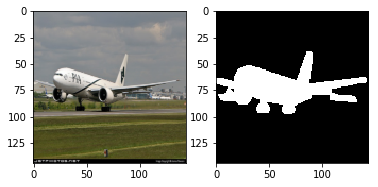

In [0]:
plt.subplot(1,2,1)
plt.imshow(x_train[9])
plt.subplot(1,2,2)
plt.imshow(y_train[9], cmap='gray')
plt.show()

In [0]:
#Transform the images targets/labels so that contain only 0 and 1
y_train = np.asarray(y_train)
y_train[y_train == 255] = 1
y_val = np.asarray(y_val)
y_val[y_val == 255] = 1
y_train.shape
y_val.shape

(750, 144, 144)

###   **Data Augnentation:**
***Rotare by 90 degree all images in x_train and y_train so that double my train database***

In [0]:
#Rotare by 90 degree all images in x_train and y_train so that double my train database
x_train_intermediate =[]
y_train_intermediate =[]

for img in x_train:
  x_train_intermediate.append(img)

for img in y_train:
  y_train_intermediate.append(img)  
  
print(len(x_train_intermediate))
print(len(y_train_intermediate))  


for img in x_train:
  rotated = np.rot90(img)
  x_train_intermediate.append(rotated)
  
for img in y_train:
  rotated = np.rot90(img)
  y_train_intermediate.append(rotated)  

  
x_train=np.asarray(x_train_intermediate)
x_train=x_train[0:1200]
y_train=np.asarray(y_train_intermediate)
y_train=y_train[0:1200] 
  
print(len(x_train_intermediate))
print(len(y_train_intermediate))
print(len(x_train))
print(len(y_train))



749
749
1498
1498
1200
1200


### Define the auto-encoder architecture 

In [0]:
input_img = Input(shape = (144, 144, 3))

def auto_encode(input_img):
    #encoder
    conv1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool3)


    #decoder
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv4)
    up1 = UpSampling2D((2,2))(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv6)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2,2))(conv7)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3) 
    return decoded

In [0]:
autoencoder = Model(input_img, auto_encode(input_img))
autoencoder.summary() 

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 144, 144, 256)     7168      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 72, 72, 128)       295040    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 36, 36, 64)        73792     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 18, 18, 64)        0   

## Loss Functions

Reference for **Dice Loss**: [Soft Dice Loss](https://www.jeremyjordan.me/semantic-segmentation/#loss)


Actually, F1 and Dice, mean the same thing and IoU has a very similar formula to the other two. Also, from the definition of the two metrics, IoU and F-score are always within a factor of 2 of each other: F/2≤IoU≤F. And also that they meet at the extremes of one and zero under the conditions that you would expect (perfect match and completely disjoint). [Relevant Reference](https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou)

In [0]:
#Soft Dice Loss:  
# epsilon=1e-6

def diceCoeffiecient(y_true, y_pred):  
    axes = tuple(range(1, len(y_pred.shape)-1)) 
    numerator = 2. * tf.reduce_sum(y_pred * y_true, axes)
    denominator = tf.reduce_sum(tf.square(y_pred) + tf.square(y_true), axes)
    return (numerator / (denominator + tf.keras.backend.epsilon()))

  
def diceScore(y_true, y_pred):
  return tf.reduce_mean(diceCoeffiecient(y_true, y_pred))  
  
def softDiceLoss(y_true, y_pred):
  return 1 - diceScore(y_true, y_pred)



- The **Intersection over Union (IoU) metric**, also referred to as the Jaccard index, is essentially a method to quantify the percent overlap between the target mask and our prediction output. This metric is closely related to the Dice coefficient.Quite simply, the IoU metric measures the number of pixels common between the target and prediction masks divided by the total number of pixels present across both masks.The IoU score is calculated for each class separately and then averaged over all classes to provide a global, mean IoU score of our semantic segmentation prediction 
[Reference: Evaluating Image Segmentation Models](https://www.jeremyjordan.me/evaluating-image-segmentation-models/)

In [0]:
def IoU_Score(target, prediction):
  axes = tuple(range(1, len(prediction.shape)-1)) 
  intersection = tf.reduce_sum(target * prediction, axes)
  union = tf.reduce_sum(prediction + target, axes) - intersection
  iou_score = (tf.reduce_sum(intersection) + 1) / (tf.reduce_sum(union) + 1)
  
  return iou_score  



**Weighted Cross Entropy** Loss Function [Reference Link:](https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/)  
It is a variant of CE where all positive examples get weighted by some coefficient. It is used in the case of class imbalance. For example, when you have an image with 10% black pixels and 90% white pixels, regular cross entropy won’t work very well.

In order to decrease the number of false negatives, β should be > 1.
To decrease the number of false positives, β < 1.

In [0]:
def weighted_cross_entropy(beta):
  def convert_to_logits(y_pred):
      y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())

      return tf.log(y_pred / (1 - y_pred))

  def loss(y_true, y_pred):
    y_pred = convert_to_logits(y_pred)
    loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=beta)

    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

  return loss

### **Train my model without data augmentation**
- **loss='binary_crossentropy'**
- **optimizer: 'adam'**
- **shuffle=True**


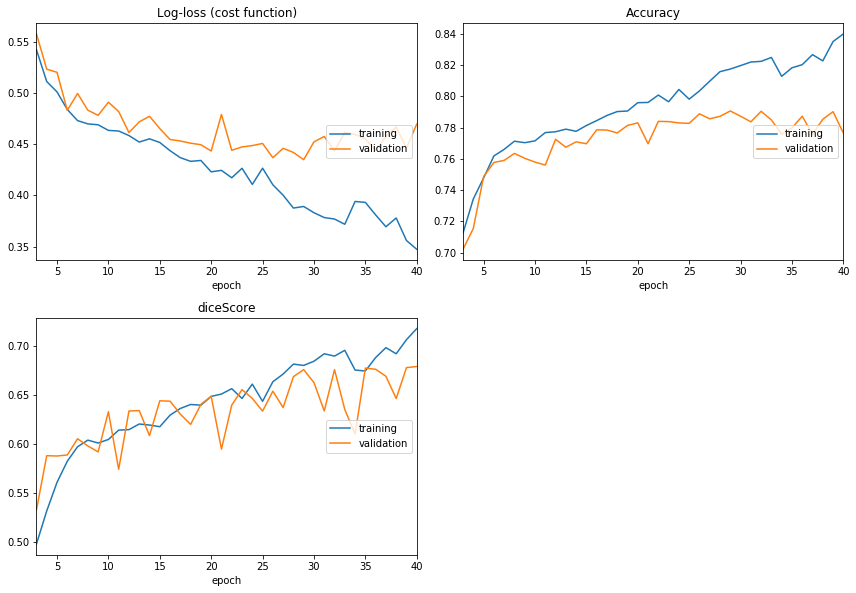

Log-loss (cost function):
training   (min:    0.347, max:    0.601, cur:    0.347)
validation (min:    0.435, max:    0.573, cur:    0.470)

Accuracy:
training   (min:    0.711, max:    0.840, cur:    0.840)
validation (min:    0.702, max:    0.791, cur:    0.777)

diceScore:
training   (min:    0.442, max:    0.718, cur:    0.718)
validation (min:    0.468, max:    0.679, cur:    0.679)


In [0]:
#Compile the model and train
autoencoder.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy', diceScore]) #here we create the model
autoencoder_train = autoencoder.fit(x_train, y_train[:,:,:,np.newaxis], epochs=40, batch_size=32, shuffle=True, verbose=2, validation_data=(x_val, y_val[:,:,:,np.newaxis]), callbacks=[PlotLossesKeras()])

In [0]:
pred =autoencoder.predict(x_val)

(-0.5, 143.5, 143.5, -0.5)

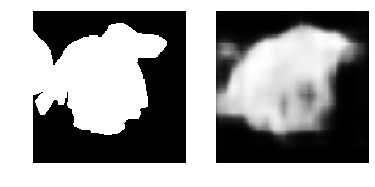

In [0]:
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[5],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(pred[5][:,:,0],cmap="gray")
plt.axis('off')

#### Apply thresholding to visualize my segmented images in a nice way. 

In [0]:
#Assign 0 and 1 only to the target predictions 
y_prediction=[]

for img in pred:      
    for i in range(len(img)):
      for j in range(len(img)):
        if img[i,j]>0.5:
          img[i,j]=1
        else:
          img[i,j]=0
            
    y_prediction.append(img)
    

(-0.5, 143.5, 143.5, -0.5)

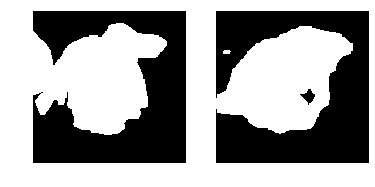

In [0]:
    # Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[5],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(pred[5][:,:,0],cmap="gray")
plt.axis('off')

- **Compute ROC**

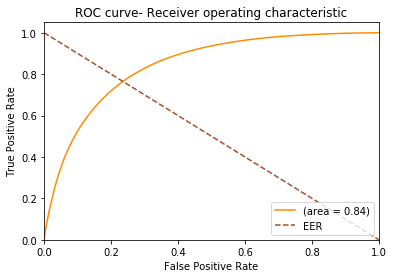

Equal Error Rate= 0.23542574668575822


In [0]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d


fpr1, tpr1, thresholds1 = roc_curve(np.asarray(y_val).flatten(), np.asarray(pred).flatten())
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='(area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
print('Equal Error Rate=', eer1)

### **Train my model with data augmentation: x_train samples=1000**
- **loss='binary_crossentropy'**
- **optimizer: 'adam'**

In [0]:
autoencoder1 = Model(input_img, auto_encode(input_img))
autoencoder1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 144, 144, 256)     7168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 128)       295040    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 64)        0   

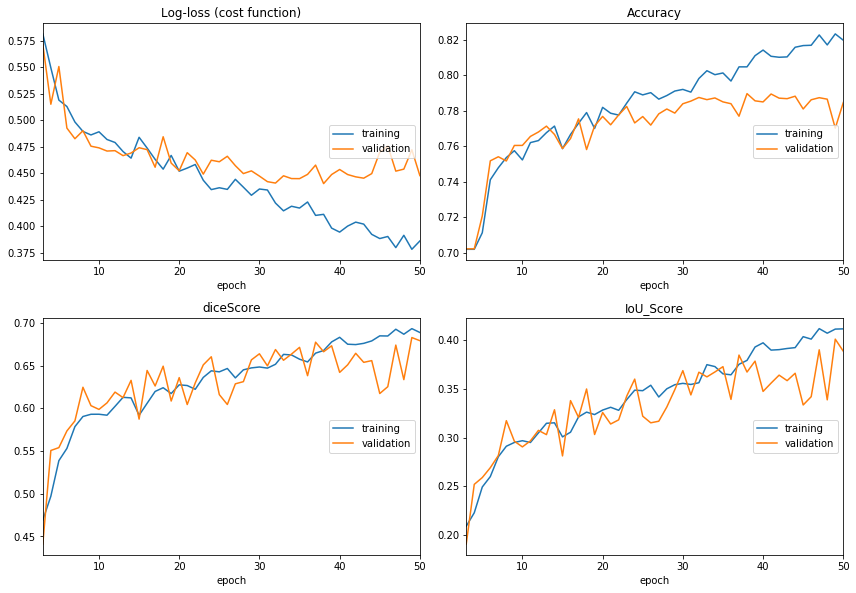

Log-loss (cost function):
training   (min:    0.378, max:    0.643, cur:    0.386)
validation (min:    0.440, max:    0.601, cur:    0.448)

Accuracy:
training   (min:    0.678, max:    0.823, cur:    0.820)
validation (min:    0.702, max:    0.790, cur:    0.785)

diceScore:
training   (min:    0.435, max:    0.693, cur:    0.689)
validation (min:    0.436, max:    0.683, cur:    0.679)

IoU_Score:
training   (min:    0.192, max:    0.412, cur:    0.412)
validation (min:    0.185, max:    0.401, cur:    0.389)


In [0]:
#Compile the model and train
autoencoder1.compile(loss='binary_crossentropy', optimizer ='adam', metrics=['accuracy', diceScore, IoU_Score])
autoencoder_train1 = autoencoder1.fit(x_train, y_train[:,:,:,np.newaxis], epochs=50, batch_size=64, verbose=2, validation_data=(x_val, y_val[:,:,:,np.newaxis]), callbacks=[PlotLossesKeras()])

In [0]:
pred1 =autoencoder1.predict(x_val)

(-0.5, 143.5, 143.5, -0.5)

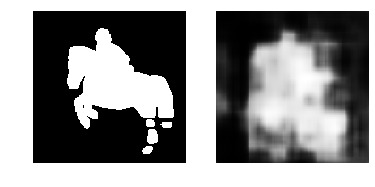

In [0]:
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[23],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(pred1[23][:,:,0],cmap="gray")
plt.axis('off')

#### Apply thresholding to visualize my segmented images in a nice way. 

In [0]:
#Assign 0 and 1 only to the target predictions 
def blackAndWhite(arr):
  y_prediction=[]

  for img in arr:
    for i in range(len(img)):
      for j in range(len(img)):
        if img[i,j]>0.5:
          img[i,j]=1
        else:
          img[i,j]=0
            
    y_prediction.append(img)
  return y_prediction   

In [0]:
#transform prediction to 0 and 1
y_pred=blackAndWhite(pred1) 

(-0.5, 143.5, 143.5, -0.5)

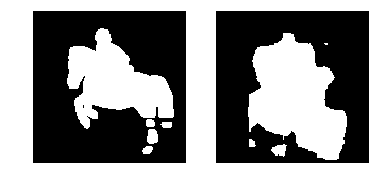

In [0]:
 # Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[23],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(y_pred[23][:,:,0],cmap="gray")
plt.axis('off')

* **ROC Curve**

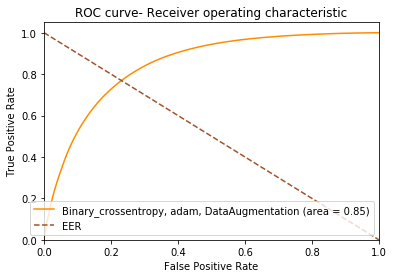

Equal Error Rate= 0.23108404063786006


In [0]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d


fpr1, tpr1, thresholds1 = roc_curve(np.asarray(y_val).flatten(), np.asarray(pred1).flatten())
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='Binary_crossentropy, adam, DataAugmentation (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
print('Equal Error Rate=', eer1)

### **Train my model without data augmentation**
- **loss='softDiceLoss'**
- **optimizer: 'adam'**

In [0]:
autoencoder2 = Model(input_img, auto_encode(input_img))
autoencoder2.summary()

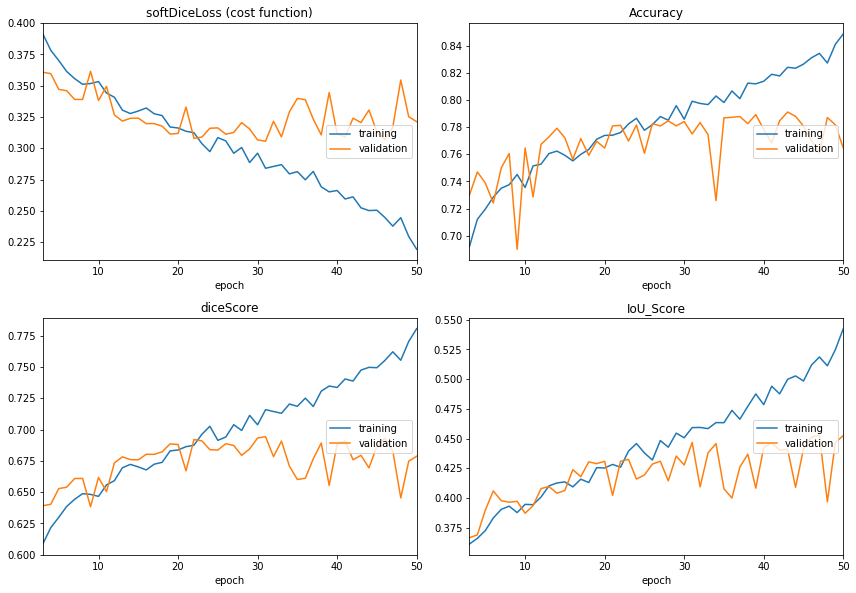

softDiceLoss (cost function):
training   (min:    0.219, max:    0.492, cur:    0.219)
validation (min:    0.306, max:    0.463, cur:    0.321)

Accuracy:
training   (min:    0.470, max:    0.849, cur:    0.849)
validation (min:    0.583, max:    0.791, cur:    0.765)

diceScore:
training   (min:    0.508, max:    0.781, cur:    0.781)
validation (min:    0.537, max:    0.694, cur:    0.679)

IoU_Score:
training   (min:    0.282, max:    0.543, cur:    0.543)
validation (min:    0.262, max:    0.453, cur:    0.453)


In [0]:
#Compile the model and train
autoencoder2.compile(loss=softDiceLoss, optimizer ='adam', metrics=['accuracy', diceScore, IoU_Score])
autoencoder_train2 = autoencoder2.fit(x_train, y_train[:,:,:,np.newaxis], epochs=50, batch_size=64, verbose=2, validation_data=(x_val, y_val[:,:,:,np.newaxis]), callbacks=[PlotLossesKeras()])

In [0]:
pred2 =autoencoder2.predict(x_val)

(-0.5, 143.5, 143.5, -0.5)

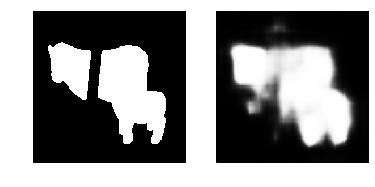

In [0]:
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[500],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(pred2[500][:,:,0],cmap="gray")
plt.axis('off')

#### Apply thresholding to visualize my segmented images in a nice way. 

In [0]:
#transform prediction to 0 and 1
y_pred2=blackAndWhite(pred2) 

(-0.5, 143.5, 143.5, -0.5)

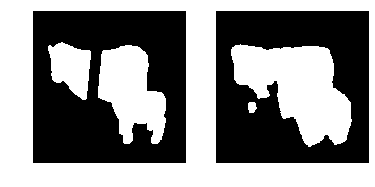

In [0]:
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[500],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(y_pred2[500][:,:,0],cmap="gray")
plt.axis('off')

* **ROC Curve**

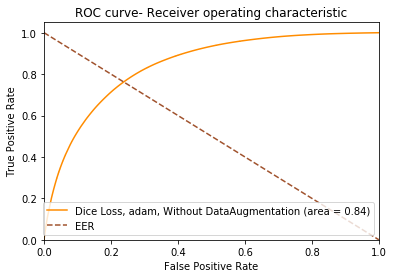

Equal Error Rate= 0.2377637321275584


In [0]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d


fpr1, tpr1, thresholds1 = roc_curve(np.asarray(y_val).flatten(), np.asarray(pred2).flatten())
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='Dice Loss, adam, Without DataAugmentation (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
print('Equal Error Rate=', eer1)

### **Train my model with data augmentation: x_train=1100 - Proves to be slightly better than the one without data augmentation**
- **loss='softDiceLoss'**
- **optimizer: 'adam'**  

In [0]:
autoencoder6 = Model(input_img, auto_encode(input_img))
autoencoder6.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 144, 144, 256)     7168      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 72, 72, 128)       295040    
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 36, 36, 64)        73792     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 18, 18, 64)        0   

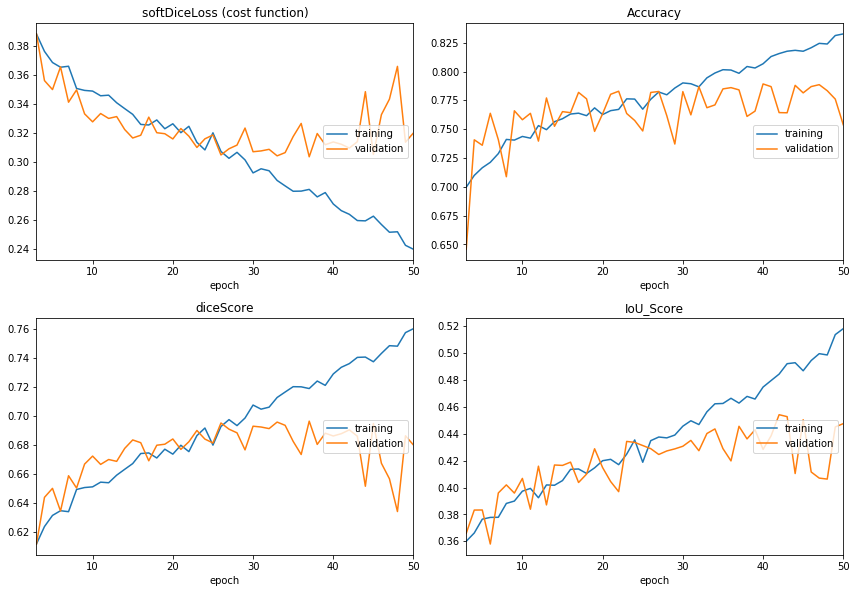

softDiceLoss (cost function):
training   (min:    0.240, max:    0.491, cur:    0.240)
validation (min:    0.304, max:    0.444, cur:    0.320)

Accuracy:
training   (min:    0.435, max:    0.833, cur:    0.833)
validation (min:    0.646, max:    0.789, cur:    0.754)

diceScore:
training   (min:    0.509, max:    0.760, cur:    0.760)
validation (min:    0.556, max:    0.696, cur:    0.680)

IoU_Score:
training   (min:    0.268, max:    0.518, cur:    0.518)
validation (min:    0.271, max:    0.454, cur:    0.447)


In [0]:
#Compile the model and train
autoencoder6.compile(loss=softDiceLoss, optimizer = "adam", metrics=['accuracy', diceScore, IoU_Score])
autoencoder_train6 = autoencoder6.fit(x_train, y_train[:,:,:,np.newaxis], epochs=50, shuffle=True, batch_size=64, verbose=2, validation_data=(x_val, y_val[:,:,:,np.newaxis]), callbacks=[PlotLossesKeras()])

In [0]:
pred6=autoencoder6.predict(x_val)

(-0.5, 143.5, 143.5, -0.5)

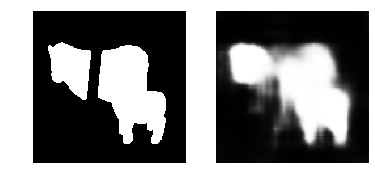

In [0]:
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[500],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(pred6[500][:,:,0],cmap="gray")
plt.axis('off')

#### Apply thresholding for better visualization of the segmented image

(-0.5, 143.5, 143.5, -0.5)

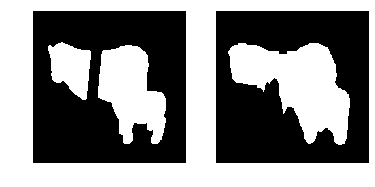

In [0]:
#transform prediction to 0 and 1
y_pred6=blackAndWhite(pred6) 
#Visualize output
# Display an image as output from the auto-endocder
plt.subplot(121)
plt.imshow(y_val[500],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(y_pred6[500][:,:,0],cmap="gray")
plt.axis('off')

### **Data Augmentation: x_train=1200**
- **loss='Weighted Cross Entropy', β=3**
- **optimizer: 'adam'**


### *Applied early-stopping in order to avoid overfitting*

In [0]:
autoencoder7 = Model(input_img, auto_encode(input_img))
#autoencoder7.summary()

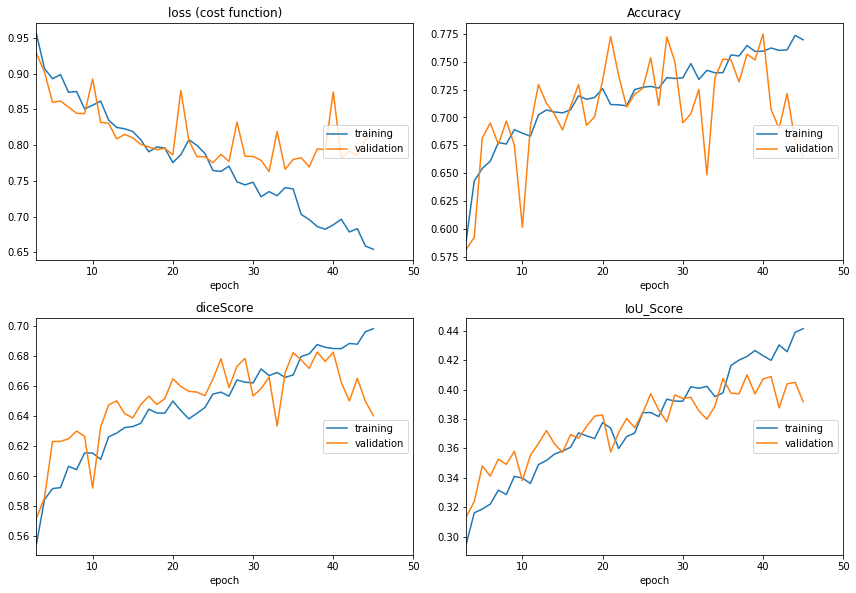

loss (cost function):
training   (min:    0.654, max:    1.065, cur:    0.654)
validation (min:    0.763, max:    0.997, cur:    0.816)

Accuracy:
training   (min:    0.396, max:    0.774, cur:    0.770)
validation (min:    0.450, max:    0.775, cur:    0.665)

diceScore:
training   (min:    0.497, max:    0.698, cur:    0.698)
validation (min:    0.536, max:    0.683, cur:    0.640)

IoU_Score:
training   (min:    0.247, max:    0.441, cur:    0.441)
validation (min:    0.273, max:    0.410, cur:    0.392)
Epoch 46/50


KeyboardInterrupt: ignored

In [0]:
#Compile the model and train
autoencoder7.compile(loss=weighted_cross_entropy(3), optimizer = "adam", metrics=['accuracy', diceScore, IoU_Score])
autoencoder_train7 = autoencoder7.fit(x_train, y_train[:,:,:,np.newaxis], epochs=50, shuffle=True, batch_size=64, verbose=2, validation_data=(x_val, y_val[:,:,:,np.newaxis]), callbacks=[PlotLossesKeras()])

In [0]:
pred7=autoencoder7.predict(x_val)

(-0.5, 143.5, 143.5, -0.5)

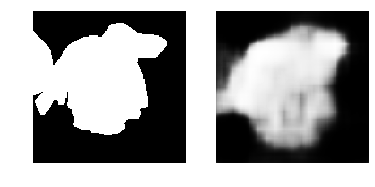

In [0]:
#Visualize output
plt.subplot(121)
plt.imshow(y_val[5],cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(pred7[5][:,:,0],cmap="gray")
plt.axis('off')


(-0.5, 143.5, 143.5, -0.5)

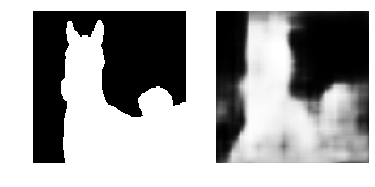

In [0]:
plt.subplot(121)
plt.imshow(y_val[24],cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(pred7[24][:,:,0],cmap="gray")
plt.axis('off')

#### Apply thresholding for better visualization of the segmented images

(-0.5, 143.5, 143.5, -0.5)

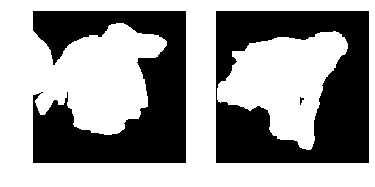

In [0]:
#transform prediction to 0 and 1
y_pred7=blackAndWhite(pred7) 
#Visualize output
plt.subplot(121)
plt.imshow(y_val[5],cmap="gray")
plt.axis('off')
plt.subplot(122)
plt.imshow(y_pred6[5][:,:,0],cmap="gray")
plt.axis('off')

(-0.5, 143.5, 143.5, -0.5)

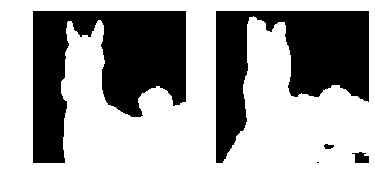

In [0]:
plt.subplot(121)
plt.imshow(y_val[24],cmap="gray")
plt.axis('off')
# Display the first image in testing data
plt.subplot(122)
plt.imshow(y_pred6[24][:,:,0],cmap="gray")
plt.axis('off')

* **ROC Curve**

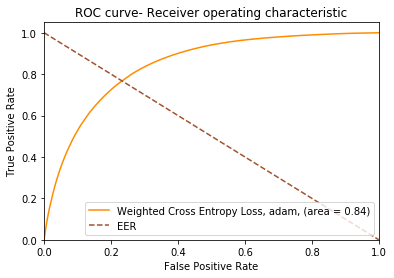

Equal Error Rate= 0.2325624552603828


In [0]:
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d


fpr1, tpr1, thresholds1 = roc_curve(np.asarray(y_val).flatten(), np.asarray(pred7).flatten())
roc_auc1 = auc(fpr1, tpr1)

plt.figure()
plt.plot(fpr1, tpr1, color='darkorange', label='Weighted Cross Entropy Loss, adam, (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [1, 0], color='sienna', linestyle='--', label='EER')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve- Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#Calculate the EER for each case
eer1 = brentq(lambda x : 1. - x - interp1d(fpr1, tpr1)(x), 0., 1.)
print('Equal Error Rate=', eer1)

## References

- https://lars76.github.io/neural-networks/object-detection/losses-for-segmentation/
- https://www.jeremyjordan.me/semantic-segmentation/#loss
- https://stats.stackexchange.com/questions/273537/f1-dice-score-vs-iou
- https://www.jeremyjordan.me/evaluating-image-segmentation-models/